In [8]:
import sys
#!{sys.executable} -m pip install tifffile
#!{sys.executable} -m pip install scikit-image

In [69]:
!ls masks/ | head

M-33-20-D-c-4-2.tif
M-33-20-D-d-3-3.tif
M-33-32-B-b-4-4.tif
M-33-48-A-c-4-4.tif
M-33-7-A-d-2-3.tif
M-33-7-A-d-3-2.tif
M-34-32-B-a-4-3.tif
M-34-32-B-b-1-3.tif
M-34-5-D-d-4-2.tif
M-34-51-C-b-2-1.tif


In [102]:
!ls masks | wc -l

      41


In [71]:
#!{sys.executable} -m pip install imagecodecs-lite

In [2]:
M.shape

(9429, 8973)

In [3]:
I.shape

(9429, 8973, 3)

(9429, 8973, 3)


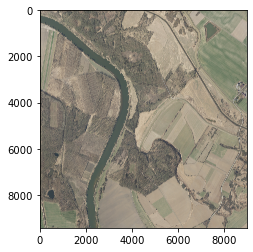

In [9]:
import tifffile
from matplotlib import pyplot as plt
import numpy as np
# M = tifffile.imread('masks/M-33-20-D-c-4-2.tif')

# let us first look at a single image:
fname = 'M-33-48-A-c-4-4.tif'
#'N-34-97-D-c-2-4.tif'
#

M = tifffile.imread('masks/' + fname)
I = tifffile.imread('images/' + fname)
print(I.shape)
M[M != 3] = 0
M[M == 3] = 255
I = np.concatenate([I, M[..., None]], axis=-1)
plt.imshow(I[:, :, :3])

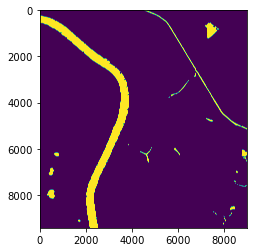

In [115]:
# the mask is the fourth channel:
plt.imshow(I[:, :, 3])

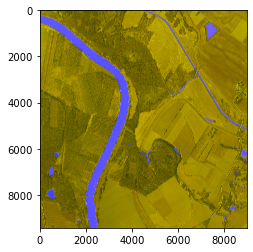

In [129]:
plt.imshow(I[:, :, 1:4])

In [94]:
M.shape

(9429, 8973)

In [95]:
I.shape

(9429, 8973, 4)

In [96]:
type(M), M.dtype, M.shape, np.unique(M)

(numpy.ndarray, dtype('uint8'), (9429, 8973), array([  0, 255], dtype=uint8))

In [99]:
#!{sys.executable} -m pip install -U imagecodecs

In [97]:
sys.version

'3.8.3 (default, Jul  2 2020, 11:26:31) \n[Clang 10.0.0 ]'

In [100]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [131]:
def split_image(im, H, W):
    tiles = [im[i:i+H,j:j+W] for i in range(0,im.shape[0]-H,H) for j in range(0,im.shape[1]-W,W)]
    return tiles
tiles_single = split_image(I, 448, 448);

In [132]:
tiles_single[-1].shape, len(tiles_single)

((448, 448, 4), 420)

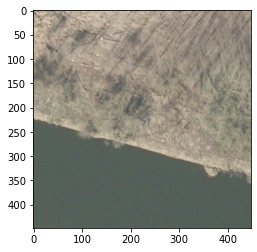

In [136]:
plt.imshow(tiles_single[0][:, :, :3])

100%|██████████| 14188/14188 [01:02<00:00, 228.15it/s]


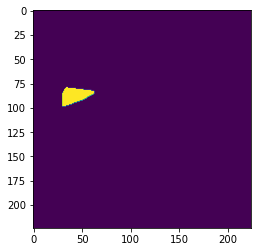

In [298]:
import cv2
import os

from tqdm import tqdm

import tifffile
from matplotlib import pyplot as plt
import numpy as np
# M = tifffile.imread('masks/M-33-20-D-c-4-2.tif')

fname = 'M-33-48-A-c-4-4.tif'

def imread(fname):
    M = tifffile.imread('masks/' + fname)
    I = tifffile.imread('images/' + fname)
    M[M != 3] = 0
    M[M == 3] = 255
    I = np.concatenate([I, M[..., None]], axis=-1)
    return I

def split_image(im, H, W):
    tiles = [im[i:i+H,j:j+W] for i in range(0,im.shape[0]-H,H) for j in range(0,im.shape[1]-W,W)]
    return tiles

tiles = []
for fname in tqdm(os.listdir('images')):
    if not fname.endswith('tif'):
        continue
    I = imread(fname)
    tiles += split_image(I, 448, 448)

# tiles = split_image(I, 448, 448);

import shutil
shutil.rmtree('dataset')
shutil.rmtree('dataset_check/images')
shutil.rmtree('dataset_check/masks')

os.makedirs('dataset', exist_ok=True)
os.makedirs('dataset_check/images', exist_ok=True)
os.makedirs('dataset_check/masks', exist_ok=True)


# tiles_resized = []
i = 0
list_mv = []
list_overpopulated = []
from collections import Counter
for image in tqdm(tiles):
    # dummy filter
    # 
    if image[:, :, -1].max() == 0 or image[:, :, -1].min() == 255:
        continue
    image_resized = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
    MM = image_resized[:, :, -1].copy()
    MM[MM < 128] = 0
    MM[MM >= 128] = 1
    image_resized[:, :, -1] = MM
    i += 1
    mv = image_resized[:, :, -1].mean().item() // 0.1
    list_mv.append(mv)

    water_counter = Counter(item for item in list_mv) 

    for k in water_counter:
        if water_counter[k]> 200:
            list_overpopulated.append(k)
    if mv in list_overpopulated:
        continue
    cv2.imwrite(f'dataset/{i}.png',image_resized[:, :, [2,1,0,3]])
    cv2.imwrite(f'dataset_check/masks/{i}.png',image_resized[:, :, 3] * 255)
    cv2.imwrite(f'dataset_check/images/{i}.png',image_resized[:, :, [2,1,0]])

    # tiles_resized.append(image_resized)
plt.imshow(MM)

In [199]:
!ls dataset | wc -l

    1328


In [299]:
from collections import Counter
test = Counter([cv2.imread(f'dataset/{fname}', cv2.IMREAD_UNCHANGED)[:, :, -1].mean() 
                        // 0.1 for fname in os.listdir('dataset') if fname.endswith('.png')])

Counter({1.0: 200,
         3.0: 146,
         2.0: 200,
         7.0: 101,
         9.0: 161,
         8.0: 90,
         6.0: 85,
         0.0: 200,
         4.0: 122,
         5.0: 117})

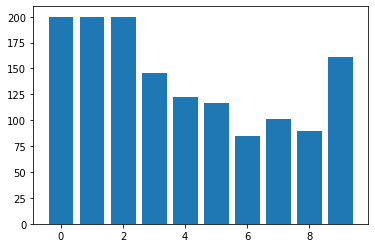

In [300]:
import collections
import matplotlib.pyplot as plt

plt.bar(test.keys(), test.values())
test

In [47]:
#! ls -alh dataset.zip

-rw-r--r--  1 olgadimitrova  staff   254M Sep  6 19:32 dataset.zip


In [46]:
#! zip dataset.zip -r dataset

  adding: dataset/ (stored 0%)
  adding: dataset/348.png (deflated 9%)
  adding: dataset/1804.png (deflated 16%)
  adding: dataset/1810.png (deflated 2%)
  adding: dataset/1186.png (deflated 1%)
  adding: dataset/412.png (deflated 3%)
  adding: dataset/374.png (deflated 9%)
  adding: dataset/1838.png (deflated 2%)
  adding: dataset/360.png (deflated 1%)
  adding: dataset/406.png (deflated 2%)
  adding: dataset/1192.png (deflated 1%)
  adding: dataset/1179.png (deflated 2%)
  adding: dataset/2470.png (deflated 1%)
  adding: dataset/2316.png (deflated 4%)
  adding: dataset/2302.png (deflated 6%)
  adding: dataset/2464.png (deflated 4%)
  adding: dataset/1145.png (deflated 0%)
  adding: dataset/1623.png (deflated 4%)
  adding: dataset/1637.png (deflated 6%)
  adding: dataset/1151.png (deflated 2%)
  adding: dataset/2458.png (deflated 4%)
  adding: dataset/638.png (deflated 2%)
  adding: dataset/176.png (deflated 8%)
  adding: dataset/88.png (deflated 3%)
  adding: dataset/610.png (deflate

(array([[224.,   0.,   0., ...,   0.,   0.,   0.],
        [224.,   0.,   0., ...,   0.,   0.,   0.],
        [224.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [224.,   0.,   0., ...,   0.,   0.,   0.],
        [224.,   0.,   0., ...,   0.,   0.,   0.],
        [224.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 224 Lists of Patches objects>)

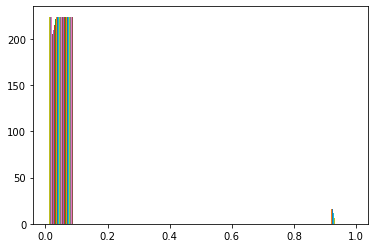

In [301]:
plt.hist(MM)